<a href="https://colab.research.google.com/github/mk3920columbia/applied-dl-project/blob/master/project_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Data

In [0]:
all_data = pd.read_csv('/content/gdrive/My Drive/Project_DL/weather_solar_data_updated.csv')

In [4]:
print(all_data)

             Date  Hour  Cloud_coverage  ...  Altimeter  Solar_energy  Sun_elevation
0       1/31/2016    24            0.00  ...      29.89          0.00          0.000
1        2/1/2016     1            0.00  ...      29.90          0.00          0.000
2        2/1/2016     2            0.00  ...      29.91          0.00          0.000
3        2/1/2016     3            0.00  ...      29.93          0.00          0.000
4        2/1/2016     4            0.00  ...      29.94          0.00          0.000
5        2/1/2016     5            0.00  ...      29.95          0.00          0.000
6        2/1/2016     6            0.00  ...      29.98          0.00          0.000
7        2/1/2016     7            0.00  ...      29.99         84.29          4.550
8        2/1/2016     8            0.14  ...      30.01        531.00         13.660
9        2/1/2016     9            0.92  ...      30.04        923.75         21.945
10       2/1/2016    10            0.46  ...      30.06       194

In [5]:
print(all_data.columns)

Index(['Date', 'Hour', 'Cloud_coverage', 'Visibility', 'Temperature',
       'Dew_point', 'Relative_humidity', 'Wind_speed', 'Station_pressure',
       'Altimeter', 'Solar_energy', 'Sun_elevation'],
      dtype='object')


In [6]:
slength = len(all_data.Hour)
print(slength)

14328


In [7]:
no_days = slength/24
no_days = int(no_days)
print(no_days)

597


In [0]:
new_data = all_data.copy()
new_data = new_data.drop('Date', axis=1)

In [0]:
!pip install -q sklearn

In [10]:
from __future__ import absolute_import, division, print_function

!pip install -q tensorflow==2.0.0-alpha0
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 79.9MB 1.9MB/s 
     |████████████████████████████████| 3.0MB 43.8MB/s 
     |████████████████████████████████| 61kB 24.1MB/s 
     |████████████████████████████████| 419kB 52.4MB/s 


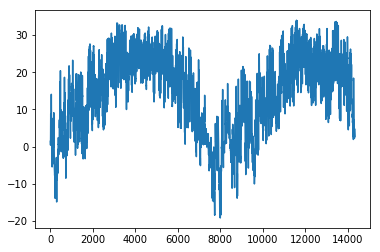

In [11]:
plt.plot(new_data['Temperature'])

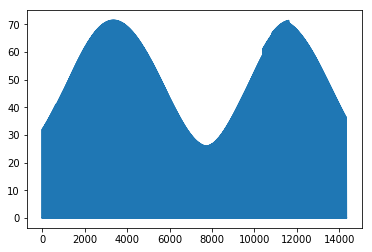

In [12]:
plt.plot(new_data['Sun_elevation'])

Data Preprocessing for Training

In [86]:
dataframe = new_data
train, tmp = train_test_split(dataframe, test_size=0.35)
val, test = train_test_split(tmp, test_size=3/7)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

9313 train examples
2865 validation examples
2150 test examples


In [0]:
mean = train.mean(axis = 0) # we need these for normalization of the input data
tmp = train - mean
std = tmp.std(axis=0)
mean = mean.drop('Solar_energy',axis=0)
std = std.drop('Solar_energy',axis=0)

In [0]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Solar_energy') # this is a regression problem, 
  #"labels" are in fact targets here
  dataframe -= mean
  dataframe /= std
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [0]:
batch_size = 16
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [19]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))

Every feature: ['Hour', 'Cloud_coverage', 'Visibility', 'Temperature', 'Dew_point', 'Relative_humidity', 'Wind_speed', 'Station_pressure', 'Altimeter', 'Sun_elevation']


In [0]:
example_batch = next(iter(train_ds))[0]

In [0]:
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

In [0]:
feature_columns = []

# numeric cols
for header in ['Hour','Cloud_coverage', 'Visibility' ,'Temperature', 'Dew_point','Relative_humidity', 'Station_pressure' ,'Wind_speed', 'Sun_elevation']:
  feature_columns.append(feature_column.numeric_column(header))
  
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

Training

In [0]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(256, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [0]:
EPOCHS = 70
history = model.fit(train_ds, 
          validation_data=val_ds, 
          epochs=EPOCHS)

W0501 23:33:53.405086 140146499643264 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column_v2.py:2758: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Epoch 1/70
583/583 [==============================] - 10s 18ms/step - loss: 590828.6859 - mae: 598.4655 - val_loss: 257041.0715 - val_mae: 277.0688
Epoch 2/70
583/583 [==============================] - 11s 19ms/step - loss: 252343.5617 - mae: 279.4300 - val_loss: 232468.9717 - val_mae: 254.0946
Epoch 3/70
583/583 [==============================] - 10s 18ms/step - loss: 230946.2889 - mae: 265.7047 - val_loss: 212028.7796 - val_mae: 238.0889
Epoch 4/70
583/583 [==============================] - 10s 18ms/step - loss: 220607.5928 - mae: 257.0424 - val_loss: 202950.9556 - val_mae: 230.5009
Epoch 5/70
583/583 [==============================] - 10s 18ms/step - loss: 214202.3671 - mae: 250.6156 - val_loss: 203925.7708 - val_mae: 229.2849
Epoch 6/70
583/583 [==============================] - 10s 18ms/step - loss: 205825.7405 - mae: 245.2084 - val_loss: 196034.7599 - val_mae: 223.1422
Epoch 7/70
583/583 [==============================] - 10s 17ms/step - loss: 201466.7570 - mae: 239.6254 - val_lo

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2560      
_________________________________________________________________
dense_1 (Dense)              multiple                  65792     
_________________________________________________________________
dense_2 (Dense)              multiple                  65792     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  257       
Total params: 134,401
Trainable params: 134,401
Non-trainable params: 0
__________________________________________________

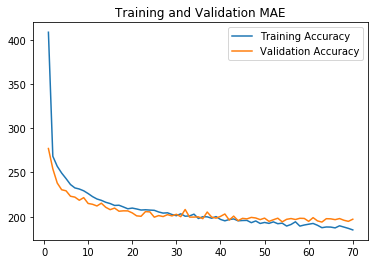

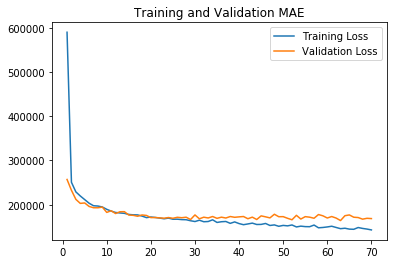

In [0]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')
plt.show()


plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')
plt.show()

In [90]:
loss, mae = model.evaluate(test_ds)
print("MAE", mae)

135/135 [==============================] - 1s 6ms/step - loss: 137875.8711 - mae: 184.0110
MAE 184.01096


Save the model weights for future use:

In [0]:
# Save the weights
#model.save_weights('/content/gdrive/My Drive/Project_DL/checkpoints/checkpoint_05_01')

Compute the nominal estimation errors:

In [0]:
dataframe = new_data
train = dataframe

nominal_error_stats = np.zeros(len(train))
predicted_powers = np.zeros(len(train))
observed_powers = np.zeros(len(train))

for num in range(0,len(train)):
  df = train.iloc[num,:]
  df = df.copy()
  label = df.pop('Solar_energy')
  observed_powers[num] = label
  df -= mean
  df /= std
  ds = tf.data.Dataset.from_tensors((dict(df), label))  
  ds = ds.batch(1)
  tmp = ds.take(1)
  loss, mae = model.evaluate(tmp)
  nominal_error_stats[num] = mae
  predicted_powers[num] = model.predict(tmp)

Save the estimation errors and estimated power generation for future use:

In [0]:
nominal_error_stats.tofile("/content/gdrive/My Drive/Project_DL/nominal_errors_updated")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/nominal_error_stats_all_updated.csv", delimiter=",", X=nominal_error_stats)
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/predicted_powers_all.csv", delimiter=",", X=predicted_powers)
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/observed_powers_all.csv", delimiter=",", X=observed_powers)

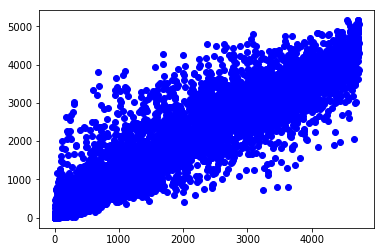

In [0]:
plt.plot(observed_powers, predicted_powers, 'bo', label='Estimated Power vs. Actual Power')

In [36]:
print(np.mean(nominal_error_stats))

181.84293093520415


We next restore the model weights and continue on the performance evaluation:

In [22]:
def create_model():
  model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
  ])
  model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  return model

# Restore the weights
new_model = create_model()
new_model.load_weights('/content/gdrive/My Drive/Project_DL/checkpoints/checkpoint_05_01')

In [0]:
EPOCHS = 0
history = new_model.fit(train_ds, 
          validation_data=val_ds, 
          epochs=EPOCHS)

In [0]:
nominal_error_stats_2 = np.fromfile("/content/gdrive/My Drive/Project_DL/nominal_errors_updated")

Daytime and Nighttime Nominal Estimation Errors:

In [37]:
tmp_errs = nominal_error_stats_2.copy()
tmp_errs = tmp_errs[1:8761]
print(len(tmp_errs))
errors_night = np.zeros(3285)
errors_day = np.zeros(5475)  # 5:00 am - 8:00 pm
for num in range(0,365):
  errors_night[num*9:num*9+5] = tmp_errs[num*24:num*24+5]
  errors_day[num*15:num*15+15] = tmp_errs[num*24+5:num*24+20]  
  errors_night[num*9+5:num*9+9] = tmp_errs[num*24+20:num*24+24]

8760


In [0]:
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/errors_night.csv", delimiter=",", X=errors_night)
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/errors_day.csv", delimiter=",", X=errors_day)

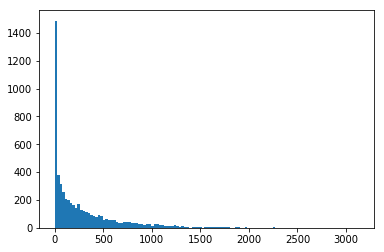

In [39]:
plt.hist(errors_day,bins=120)
plt.show()

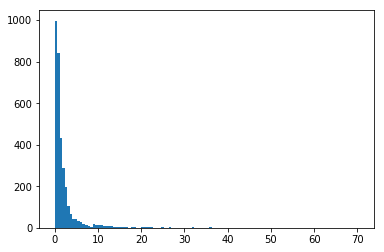

In [40]:
plt.hist(errors_night,bins=120)
plt.show()

Compute and save the p-values for nominal data:

In [0]:
from math import log
decision_stat = 0.0
alpha = 0.1
decision_stat_beta = 0.0
beta = 0.05
decision_stat_gamma = 0.0
gamma = 0.01
decision_stat_zeta = 0.0
zeta = 0.2

new_data2 = all_data.copy()
new_data2 = new_data2.drop('Date', axis=1)

vlength = len(new_data2)
dec_stat_vec = np.zeros(vlength)
dec_stat_vec_beta = np.zeros(vlength)
dec_stat_vec_gamma = np.zeros(vlength)
dec_stat_vec_zeta = np.zeros(vlength)
tail_prob_vec = np.zeros(vlength)

for num in range(0,vlength-2):
  mae = nominal_error_stats_2[num+1]
  
  rem = num % 24
  if  rem < 5:
    tail_prob = sum(errors_night > mae)/len(errors_night)
    if tail_prob == 0.0:
      tail_prob = 1/(len(errors_night)) 
  elif rem >= 20:
    tail_prob = sum(errors_night > mae)/len(errors_night)
    if tail_prob == 0.0:
      tail_prob = 1/(len(errors_night))
  else:
    tail_prob = sum(errors_day > mae)/len(errors_day)
    if tail_prob == 0.0:
      tail_prob = 1/(len(errors_day))
  
  tail_prob_vec[num] = tail_prob
  
  decision_stat = max(0.0, decision_stat+log(alpha/tail_prob))
  dec_stat_vec[num] = decision_stat
  decision_stat_beta = max(0.0, decision_stat_beta+log(beta/tail_prob))
  dec_stat_vec_beta[num] = decision_stat_beta
  decision_stat_gamma = max(0.0, decision_stat_gamma+log(gamma/tail_prob))
  dec_stat_vec_gamma[num] = decision_stat_gamma
  decision_stat_zeta = max(0.0, decision_stat_zeta+log(zeta/tail_prob))
  dec_stat_vec_zeta[num] = decision_stat_zeta
  

In [0]:
tail_prob_vec.tofile("/content/gdrive/My Drive/Project_DL/tail_prob_vec")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/tail_probabilities_all.csv", delimiter=",", X=tail_prob_vec)  
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/dec_stat_vec_0p1_all.csv", delimiter=",", X=dec_stat_vec)
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/dec_stat_vec_0p01_all.csv", delimiter=",", X=dec_stat_vec_gamma)
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/dec_stat_vec_0p05_all.csv", delimiter=",", X=dec_stat_vec_beta)
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/dec_stat_vec_0p2_all.csv", delimiter=",", X=dec_stat_vec_zeta)

In [0]:
predicted_powers = np.loadtxt(fname="/content/gdrive/My Drive/Project_DL/predicted_powers_all.csv", delimiter=",")
observed_powers = np.loadtxt(fname="/content/gdrive/My Drive/Project_DL/observed_powers_all.csv", delimiter=",")
tail_prob_vec = np.fromfile("/content/gdrive/My Drive/Project_DL/tail_prob_vec")

Creating subsets to obtain a continuous data stream for the performance evaluation:

In [0]:
winter_hourly_nominal_errors = np.zeros((82,24))
winter_hourly_predicted_powers = np.zeros((82,24))
winter_hourly_observed_powers = np.zeros((82,24))
winter_hourly_tail_probs = np.zeros((82,24))

spring_hourly_nominal_errors = np.zeros((84,24))
spring_hourly_predicted_powers = np.zeros((84,24)) 
spring_hourly_observed_powers = np.zeros((84,24)) 
spring_hourly_tail_probs = np.zeros((84,24)) 

summer_hourly_nominal_errors = np.zeros((69,24)) 
summer_hourly_predicted_powers = np.zeros((69,24))
summer_hourly_observed_powers = np.zeros((69,24))
summer_hourly_tail_probs = np.zeros((69,24)) 

fall_hourly_nominal_errors = np.zeros((87,24))
fall_hourly_predicted_powers = np.zeros((87,24))
fall_hourly_observed_powers = np.zeros((87,24)) 
fall_hourly_tail_probs = np.zeros((87,24)) 

In [43]:
print(all_data['Date'][6577])
print(all_data['Hour'][6577])

11/1/2016
1


In [0]:
for num in range(0,30):
  fall_hourly_nominal_errors[num,:] = nominal_error_stats_2[6577+num*24:6577+num*24+24] # next fall num: 30, next index: 7297
  fall_hourly_predicted_powers[num,:] = predicted_powers[6577+num*24:6577+num*24+24]
  fall_hourly_observed_powers[num,:] = observed_powers[6577+num*24:6577+num*24+24]
  fall_hourly_tail_probs[num,:] = tail_prob_vec[6576+num*24:6576+num*24+24]

In [0]:
for num in range(0,19):
  winter_hourly_nominal_errors[num,:] = nominal_error_stats_2[7297+num*24:7297+num*24+24] # next winter num: 19, next index: 7753
  winter_hourly_predicted_powers[num,:] = predicted_powers[7297+num*24:7297+num*24+24]
  winter_hourly_observed_powers[num,:] = observed_powers[7297+num*24:7297+num*24+24]
  winter_hourly_tail_probs[num,:] = tail_prob_vec[7296+num*24:7296+num*24+24]

In [0]:
for num in range(0,63):
  winter_hourly_nominal_errors[num+19,:] = nominal_error_stats_2[7753+num*24:7753+num*24+24] # next index: 9265
  winter_hourly_predicted_powers[num+19,:] = predicted_powers[7753+num*24:7753+num*24+24]
  winter_hourly_observed_powers[num+19,:] = observed_powers[7753+num*24:7753+num*24+24]
  winter_hourly_tail_probs[num+19,:] = tail_prob_vec[7752+num*24:7752+num*24+24]

In [0]:
for num in range(0,47):
  spring_hourly_nominal_errors[num,:] = nominal_error_stats_2[9265+num*24:9265+num*24+24] # next spring num: 47, next index: 10393
  spring_hourly_predicted_powers[num,:] = predicted_powers[9265+num*24:9265+num*24+24]
  spring_hourly_observed_powers[num,:] = observed_powers[9265+num*24:9265+num*24+24]
  spring_hourly_tail_probs[num,:] = tail_prob_vec[9264+num*24:9264+num*24+24]

In [0]:
for num in range(0,18):
  spring_hourly_nominal_errors[num+47,:] = nominal_error_stats_2[10393+num*24:10393+num*24+24] # next spring num: 65, next index: 10825
  spring_hourly_predicted_powers[num+47,:] = predicted_powers[10393+num*24:10393+num*24+24]
  spring_hourly_observed_powers[num+47,:] = observed_powers[10393+num*24:10393+num*24+24]
  spring_hourly_tail_probs[num+47,:] = tail_prob_vec[10392+num*24:10392+num*24+24]

In [0]:
for num in range(0,19):
  spring_hourly_nominal_errors[num+65,:] = nominal_error_stats_2[10825+num*24:10825+num*24+24] # next index: 11281
  spring_hourly_predicted_powers[num+65,:] = predicted_powers[10825+num*24:10825+num*24+24]
  spring_hourly_observed_powers[num+65,:] = observed_powers[10825+num*24:10825+num*24+24]
  spring_hourly_tail_probs[num+65,:] = tail_prob_vec[10824+num*24:10824+num*24+24]

In [0]:
for num in range(0,14):
  summer_hourly_nominal_errors[num,:] = nominal_error_stats_2[11281+num*24:11281+num*24+24] # next spring num: 14, next index: 11617 
  summer_hourly_predicted_powers[num,:] = predicted_powers[11281+num*24:11281+num*24+24]
  summer_hourly_observed_powers[num,:] = observed_powers[11281+num*24:11281+num*24+24]
  summer_hourly_tail_probs[num,:] = tail_prob_vec[11280+num*24:11280+num*24+24]

In [0]:
for num in range(0,55):
  summer_hourly_nominal_errors[num+14,:] = nominal_error_stats_2[11617+num*24:11617+num*24+24] # next index: 12937
  summer_hourly_predicted_powers[num+14,:] = predicted_powers[11617+num*24:11617+num*24+24]
  summer_hourly_observed_powers[num+14,:] = observed_powers[11617+num*24:11617+num*24+24]
  summer_hourly_tail_probs[num+14,:] = tail_prob_vec[11616+num*24:11616+num*24+24]

In [0]:
for num in range(0,57):
  fall_hourly_nominal_errors[num+30,:] = nominal_error_stats_2[12937+num*24:12937+num*24+24] # next fall num: 90, next index: 14305
  fall_hourly_predicted_powers[num+30,:] = predicted_powers[12937+num*24:12937+num*24+24]
  fall_hourly_observed_powers[num+30,:] = observed_powers[12937+num*24:12937+num*24+24]
  fall_hourly_tail_probs[num+30,:] = tail_prob_vec[12936+num*24:12936+num*24+24]

Average False Alarm Period Calculations:

In [0]:
def frange(x, y, jump):
  arr = []
  while x < y:
    arr = np.append(arr,x)
    x += jump
  return arr  
h = frange(0.01, 14.0, 0.05)
#print(h)

In [0]:
from math import log
alpha = 0.2
no_trials = 5000 # number of trials
avg_fap = np.zeros(len(h))
for num in range(0,no_trials):
  alarm_flag = np.zeros(len(h))
  decision_stat = 0
  t = 0 # time
  k = 1 # day index: btw 1 and 365
  while alarm_flag[len(h)-1] == 0:
    rem = t % 24 # hour index: btw 0 and 23
    if k<=90: # winter
      rand_ind = np.random.randint(82)
      tail_prob = winter_hourly_tail_probs[rand_ind,rem]
    elif k>90 and k<=182: # spring
      rand_ind = np.random.randint(84)
      tail_prob = spring_hourly_tail_probs[rand_ind,rem]
    elif k>182 and k<=274: # summer
      rand_ind = np.random.randint(69)
      tail_prob = summer_hourly_tail_probs[rand_ind,rem]
    elif k>274 and k<=365: # fall
      rand_ind = np.random.randint(87)
      tail_prob = fall_hourly_tail_probs[rand_ind,rem]  
      if k==365:
        k = 0       
    decision_stat = max(0.0, decision_stat+log(alpha/tail_prob))
    avg_fap = avg_fap + (t+1)*(decision_stat >= h)*(alarm_flag == 0)
    alarm_flag = alarm_flag + (decision_stat >= h)*(alarm_flag == 0)
    if rem==23:
      k = k+1
    t = t+1
avg_fap = avg_fap/no_trials       
avg_fap.tofile("/content/gdrive/My Drive/Project_DL/avg_fap_alpha_0p2")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/avg_fap_alpha_0p2.csv", delimiter=",", X=avg_fap) 


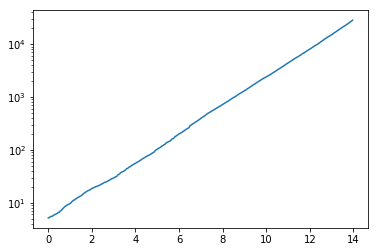

In [54]:
import scipy
avg_fap = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_fap_alpha_0p2")
plt.semilogy(h, avg_fap, label='Average False Alarm Period vs. Test Threshold')  
plt.show()

Sample Path of the Decision Statistic:

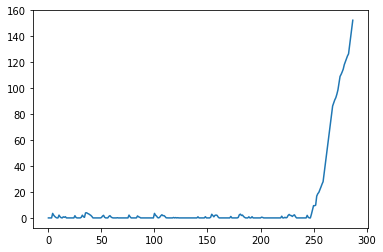

In [0]:
from math import log
alpha = 0.2
decision_stat = 0
dec_stat_vec = np.zeros(288)
FDI_mag = 1500 # attack magnitude, attack: Uniform[1000,1500)
t = 0 # time
while t<288:
  rem = t % 24 # hour index: btw 0 and 23
  rand_ind = np.random.randint(84)
  if t<248:
    tail_prob = spring_hourly_tail_probs[rand_ind,rem]
  else:
    pred_power = spring_hourly_predicted_powers[rand_ind,rem] 
    obs_power = spring_hourly_observed_powers[rand_ind,rem] + (FDI_mag*np.random.uniform(2/3,1.0))
    mae = np.abs(obs_power - pred_power) # observed mean absolute error
    if  rem < 5:
      tail_prob = sum(errors_night > mae)/len(errors_night)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_night)) 
    elif rem >= 20:
      tail_prob = sum(errors_night > mae)/len(errors_night)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_night))
    else:
      tail_prob = sum(errors_day > mae)/len(errors_day)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_day))    
  decision_stat = max(0.0, decision_stat+log(alpha/tail_prob))
  dec_stat_vec[t] = decision_stat
  if rem==23:
    k = k+1  
  t = t+1
 
plt.plot(dec_stat_vec)
plt.show()

In [0]:
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/sample_path_1000_1500_alpha_0p2.csv", delimiter=",", X=dec_stat_vec) 

Average Detection Delay and True Positive Rate Calculations:

Case 1: False Data Injection Attack:

In [0]:
from math import log
alpha = 0.2
no_trials = 10000 # number of trials
avg_det_delay = np.zeros(len(h)) # average detection delay
num_detected = np.zeros(len(h)) # number of detected trials (within max. acceptable det. delay)
FDI_mag = 1500 # attack magnitude, attack: Uniform[1000,1500)
for num in range(0,no_trials):
  alarm_flag = np.zeros(len(h))
  decision_stat = 0
  t = 8 # time
  k = np.random.randint(1,high=365) # day index: random starting point at each trial
  while alarm_flag[len(h)-1] == 0 or t<=16:
    rem = t % 24 # hour index: btw 0 and 23
    if k<=90: # winter
      rand_ind = np.random.randint(82)
      pred_power = winter_hourly_predicted_powers[rand_ind,rem] 
      if rem>=8 and rem<=15: # attack happens between 8 am - 4 pm
        obs_power = winter_hourly_observed_powers[rand_ind,rem] + (FDI_mag*np.random.uniform(2/3,1.0))
      else:
        obs_power = winter_hourly_observed_powers[rand_ind,rem]
    elif k>90 and k<=182: # spring
      rand_ind = np.random.randint(84)
      pred_power = spring_hourly_predicted_powers[rand_ind,rem]
      if rem>=8 and rem<=15:
        obs_power = spring_hourly_observed_powers[rand_ind,rem] + (FDI_mag*np.random.uniform(2/3,1.0))
      else:
        obs_power = spring_hourly_observed_powers[rand_ind,rem]
    elif k>182 and k<=274: # summer
      rand_ind = np.random.randint(69)
      pred_power = summer_hourly_predicted_powers[rand_ind,rem]
      if rem>=8 and rem<=15:
        obs_power = summer_hourly_observed_powers[rand_ind,rem] + (FDI_mag*np.random.uniform(2/3,1.0))
      else:
        obs_power = summer_hourly_observed_powers[rand_ind,rem]
    elif k>274 and k<=365: # fall
      rand_ind = np.random.randint(87)
      pred_power = fall_hourly_predicted_powers[rand_ind,rem]
      if rem>=8 and rem<=15:
        obs_power = fall_hourly_observed_powers[rand_ind,rem] + (FDI_mag*np.random.uniform(2/3,1.0))
      else:
        obs_power = fall_hourly_observed_powers[rand_ind,rem]        
      if k==365:
        k = 0     
    mae = np.abs(obs_power - pred_power) # observed mean absolute error
    if  rem < 5:
      tail_prob = sum(errors_night > mae)/len(errors_night)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_night)) 
    elif rem >= 20:
      tail_prob = sum(errors_night > mae)/len(errors_night)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_night))
    else:
      tail_prob = sum(errors_day > mae)/len(errors_day)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_day))    
    decision_stat = max(0.0, decision_stat+log(alpha/tail_prob))
    avg_det_delay = avg_det_delay + (t-8)*(decision_stat >= h)*(alarm_flag == 0) # attack starts at t=8
    alarm_flag = alarm_flag + (decision_stat >= h)*(alarm_flag == 0)
    if t==16: # attack needs to be detected within the same day (max. allowed det. delay is 8)
      num_detected = num_detected + alarm_flag   
    if rem==23:
      k = k+1
    t = t+1
avg_det_delay = avg_det_delay/no_trials   
true_positive_rate = num_detected/no_trials
avg_det_delay.tofile("/content/gdrive/My Drive/Project_DL/avg_det_delay_1000_1500_alpha_0p2")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/avg_det_delay_1000_1500_alpha_0p2.csv", delimiter=",", X=avg_det_delay) 
true_positive_rate.tofile("/content/gdrive/My Drive/Project_DL/true_positive_rate_1000_1500_alpha_0p2")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/true_positive_rate_1000_1500_alpha_0p2.csv", delimiter=",", X=true_positive_rate) 

In [0]:
avg_fap = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_fap_alpha_0p2")
avg_det_delay = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_det_delay_1000_1500_alpha_0p2")
true_positive_rate = np.fromfile("/content/gdrive/My Drive/Project_DL/true_positive_rate_1000_1500_alpha_0p2")

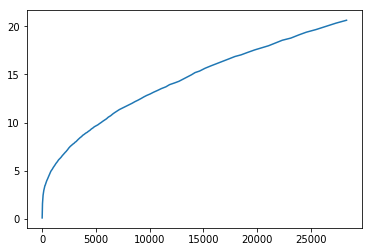

In [56]:
plt.plot(avg_fap, avg_det_delay, label='ADD_vs_FAP')
plt.show()

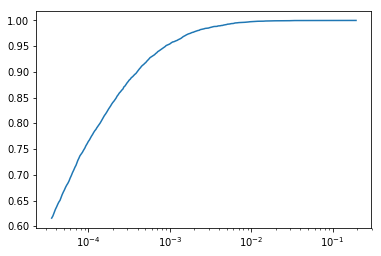

In [57]:
plt.semilogx(1/avg_fap, true_positive_rate, label='ROC_Curve')
plt.show()

Anomaly: 50% Performance Reduction:

In [0]:
from math import log
alpha = 0.2
no_trials = 10000 # number of trials
avg_det_delay = np.zeros(len(h)) # average detection delay
num_detected = np.zeros(len(h)) # number of detected trials (within max. acceptable det. delay)
for num in range(0,no_trials):
  alarm_flag = np.zeros(len(h))
  decision_stat = 0
  t = 8 # anomaly starting time (change-point)
  k = np.random.randint(1,high=365) # day index: random starting point at each trial
  while alarm_flag[len(h)-1] == 0 or t<=16:
    rem = t % 24 # hour index: btw 0 and 23
    if k<=90: # winter
      rand_ind = np.random.randint(82)
      pred_power = winter_hourly_predicted_powers[rand_ind,rem] 
      obs_power = 0.5*winter_hourly_observed_powers[rand_ind,rem]
    elif k>90 and k<=182: # spring
      rand_ind = np.random.randint(84)
      pred_power = spring_hourly_predicted_powers[rand_ind,rem]
      obs_power = 0.5*spring_hourly_observed_powers[rand_ind,rem]
    elif k>182 and k<=274: # summer
      rand_ind = np.random.randint(69)
      pred_power = summer_hourly_predicted_powers[rand_ind,rem]
      obs_power = 0.5*summer_hourly_observed_powers[rand_ind,rem]
    elif k>274 and k<=365: # fall
      rand_ind = np.random.randint(87)
      pred_power = fall_hourly_predicted_powers[rand_ind,rem]
      obs_power = 0.5*fall_hourly_observed_powers[rand_ind,rem]   
      if k==365:
        k = 0     
    mae = np.abs(obs_power - pred_power) # observed mean absolute error
    if  rem < 5:
      tail_prob = sum(errors_night > mae)/len(errors_night)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_night)) 
    elif rem >= 20:
      tail_prob = sum(errors_night > mae)/len(errors_night)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_night))
    else:
      tail_prob = sum(errors_day > mae)/len(errors_day)
      if tail_prob == 0.0:
        tail_prob = 1/(len(errors_day))    
    decision_stat = max(0.0, decision_stat+log(alpha/tail_prob))
    avg_det_delay = avg_det_delay + (t-8)*(decision_stat >= h)*(alarm_flag == 0) # attack starts at t=8
    alarm_flag = alarm_flag + (decision_stat >= h)*(alarm_flag == 0)
    if t==16: # attack needs to be detected within the same day (max. allowed det. delay is 8)
      num_detected = num_detected + alarm_flag   
    if rem==23:
      k = k+1
    t = t+1
avg_det_delay = avg_det_delay/no_trials   
true_positive_rate = num_detected/no_trials
avg_det_delay.tofile("/content/gdrive/My Drive/Project_DL/avg_det_delay_perf_red_50_alpha_0p2")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/avg_det_delay_perf_red_50_alpha_0p2.csv", delimiter=",", X=avg_det_delay) 
true_positive_rate.tofile("/content/gdrive/My Drive/Project_DL/true_positive_rate_perf_red_50_alpha_0p2")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/true_positive_rate_perf_red_50_alpha_0p2.csv", delimiter=",", X=true_positive_rate) 

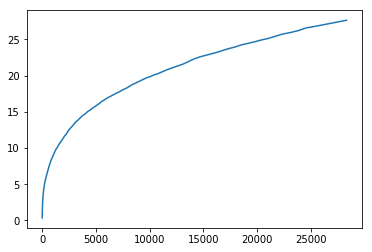

In [58]:
avg_fap = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_fap_alpha_0p2")
avg_det_delay = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_det_delay_perf_red_50_alpha_0p2")
true_positive_rate = np.fromfile("/content/gdrive/My Drive/Project_DL/true_positive_rate_perf_red_50_alpha_0p2")
plt.plot(avg_fap, avg_det_delay, label='ADD_vs_FAP')
plt.show()

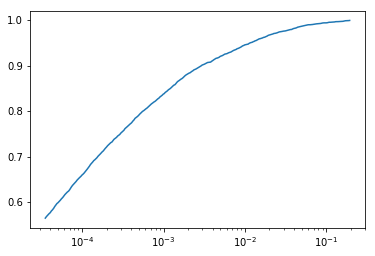

In [59]:
plt.semilogx(1/avg_fap, true_positive_rate, label='ROC_Curve')
plt.show()

**Benchmark Test: Outlier Detector based on Estimation Errors**

Average False Alarm Period

In [0]:
def frange(x, y, jump):
  arr = []
  while x < y:
    arr = np.append(arr,x)
    x += jump
  return arr  
h = frange(0.01, 2800.1, 1)

In [0]:
no_trials = 5000 # number of trials
avg_fap = np.zeros(len(h))
for num in range(0,no_trials):
  alarm_flag = np.zeros(len(h))
  t = 0 # time
  k = 1 # day index: btw 1 and 365
  while alarm_flag[len(h)-1] == 0:
    #print(t)
    rem = t % 24 # hour index: btw 0 and 23
    if k<=90: # winter
      rand_ind = np.random.randint(82)
      mae = winter_hourly_nominal_errors[rand_ind,rem]
    elif k>90 and k<=182: # spring
      rand_ind = np.random.randint(84)
      mae = spring_hourly_nominal_errors[rand_ind,rem]
    elif k>182 and k<=274: # summer
      rand_ind = np.random.randint(69)
      mae = summer_hourly_nominal_errors[rand_ind,rem]
    elif k>274 and k<=365: # fall
      rand_ind = np.random.randint(87)
      mae = fall_hourly_nominal_errors[rand_ind,rem]  
      if k==365:
        k = 0       
    decision_stat = mae
    avg_fap = avg_fap + (t+1)*(decision_stat >= h)*(alarm_flag == 0)
    alarm_flag = alarm_flag + (decision_stat >= h)*(alarm_flag == 0)
    if rem==23:
      k = k+1
    t = t+1
avg_fap = avg_fap/no_trials  
avg_fap.tofile("/content/gdrive/My Drive/Project_DL/avg_fap_outlier_detector")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/avg_fap_outlier_detector.csv", delimiter=",", X=avg_fap) 

In [0]:
print(avg_fap)

[1.0108000e+00 2.6084000e+00 3.5858000e+00 ... 7.6725984e+03 7.6725984e+03
 7.6725984e+03]


Average Detection Delay and True Positive Rate Computations:

Case 1: FDI Attack

In [0]:
no_trials = 10000 # number of trials
avg_det_delay = np.zeros(len(h)) # average detection delay
num_detected = np.zeros(len(h)) # number of detected trials (within max. acceptable det. delay)
FDI_mag = 1500 # attack magnitude, attack: Uniform[1000,1500)
for num in range(0,no_trials):
  alarm_flag = np.zeros(len(h))
  t = 8 # initial time, also change-point
  k = np.random.randint(1,high=365) # day index: random starting point at each trial
  while alarm_flag[len(h)-1] == 0 or t<=16:
    rem = t % 24 # hour index: btw 0 and 23
    if k<=90: # winter
      rand_ind = np.random.randint(82)
      pred_power = winter_hourly_predicted_powers[rand_ind,rem] 
      if rem>=8 and rem<=15: # attack happens between 8 am - 4 pm
        obs_power = winter_hourly_observed_powers[rand_ind,rem] + (FDI_mag*np.random.uniform(2/3,1.0))
      else:
        obs_power = winter_hourly_observed_powers[rand_ind,rem]
    elif k>90 and k<=182: # spring
      rand_ind = np.random.randint(84)
      pred_power = spring_hourly_predicted_powers[rand_ind,rem]
      if rem>=8 and rem<=15:
        obs_power = spring_hourly_observed_powers[rand_ind,rem] + (FDI_mag*np.random.uniform(2/3,1.0))
      else:
        obs_power = spring_hourly_observed_powers[rand_ind,rem]
    elif k>182 and k<=274: # summer
      rand_ind = np.random.randint(69)
      pred_power = summer_hourly_predicted_powers[rand_ind,rem]
      if rem>=8 and rem<=15:
        obs_power = summer_hourly_observed_powers[rand_ind,rem] + (FDI_mag*np.random.uniform(2/3,1.0))
      else:
        obs_power = summer_hourly_observed_powers[rand_ind,rem]
    elif k>274 and k<=365: # fall
      rand_ind = np.random.randint(87)
      pred_power = fall_hourly_predicted_powers[rand_ind,rem]
      if rem>=8 and rem<=15:
        obs_power = fall_hourly_observed_powers[rand_ind,rem] + (FDI_mag*np.random.uniform(2/3,1.0))
      else:
        obs_power = fall_hourly_observed_powers[rand_ind,rem]        
      if k==365:
        k = 0     
    mae = np.abs(obs_power - pred_power) # observed mean absolute error
    decision_stat = mae
    avg_det_delay = avg_det_delay + (t-8)*(decision_stat >= h)*(alarm_flag == 0) # attack starts at t=8
    alarm_flag = alarm_flag + (decision_stat >= h)*(alarm_flag == 0)
    if t==16: # attack needs to be detected within the same day (max. allowed det. delay is 8 hours)
      num_detected = num_detected + alarm_flag   
    if rem==23:
      k = k+1
    t = t+1
avg_det_delay = avg_det_delay/no_trials   
true_positive_rate = num_detected/no_trials
avg_det_delay.tofile("/content/gdrive/My Drive/Project_DL/avg_det_delay_FDI_outlier_detector")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/avg_det_delay_FDI_outlier_detector.csv", delimiter=",", X=avg_det_delay) 
true_positive_rate.tofile("/content/gdrive/My Drive/Project_DL/true_positive_rate_FDI_outlier_detector")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/true_positive_rate_FDI_outlier_detector.csv", delimiter=",", X=true_positive_rate) 

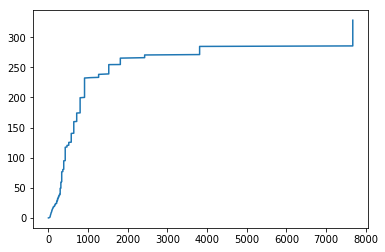

In [61]:
avg_fap = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_fap_outlier_detector")
avg_det_delay = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_det_delay_FDI_outlier_detector")
true_positive_rate = np.fromfile("/content/gdrive/My Drive/Project_DL/true_positive_rate_FDI_outlier_detector")
plt.plot(avg_fap, avg_det_delay, label='ADD_vs_FAP')
plt.show()

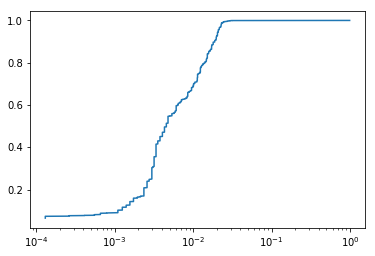

In [62]:
plt.semilogx(1/avg_fap, true_positive_rate, label='ROC_Curve')
plt.show()

Case 2: 50% Performance Loss

In [0]:
from math import log
no_trials = 10000 # number of trials
avg_det_delay = np.zeros(len(h)) # average detection delay
num_detected = np.zeros(len(h)) # number of detected trials (within max. acceptable det. delay)
for num in range(0,no_trials):
  alarm_flag = np.zeros(len(h))
  t = 8 # anomaly starting time (change-point)
  k = np.random.randint(1,high=365) # day index: random starting point at each trial
  while alarm_flag[len(h)-1] == 0 or t<=16:
    rem = t % 24 # hour index: btw 0 and 23
    if k<=90: # winter
      rand_ind = np.random.randint(82)
      pred_power = winter_hourly_predicted_powers[rand_ind,rem] 
      obs_power = 0.5*winter_hourly_observed_powers[rand_ind,rem]
    elif k>90 and k<=182: # spring
      rand_ind = np.random.randint(84)
      pred_power = spring_hourly_predicted_powers[rand_ind,rem]
      obs_power = 0.5*spring_hourly_observed_powers[rand_ind,rem]
    elif k>182 and k<=274: # summer
      rand_ind = np.random.randint(69)
      pred_power = summer_hourly_predicted_powers[rand_ind,rem]
      obs_power = 0.5*summer_hourly_observed_powers[rand_ind,rem]
    elif k>274 and k<=365: # fall
      rand_ind = np.random.randint(87)
      pred_power = fall_hourly_predicted_powers[rand_ind,rem]
      obs_power = 0.5*fall_hourly_observed_powers[rand_ind,rem]   
      if k==365:
        k = 0     
    mae = np.abs(obs_power - pred_power) # observed mean absolute error   
    decision_stat = mae
    avg_det_delay = avg_det_delay + (t-8)*(decision_stat >= h)*(alarm_flag == 0) # attack starts at t=8
    alarm_flag = alarm_flag + (decision_stat >= h)*(alarm_flag == 0)
    if t==16: # attack needs to be detected within the same day (max. allowed det. delay is 8)
      num_detected = num_detected + alarm_flag   
    if rem==23:
      k = k+1
    t = t+1
avg_det_delay = avg_det_delay/no_trials   
true_positive_rate = num_detected/no_trials
avg_det_delay.tofile("/content/gdrive/My Drive/Project_DL/avg_det_delay_perf_red_50_outlier_detector")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/avg_det_delay_perf_red_50_outlier_detector.csv", delimiter=",", X=avg_det_delay) 
true_positive_rate.tofile("/content/gdrive/My Drive/Project_DL/true_positive_rate_perf_red_50_outlier_detector")
np.savetxt(fname="/content/gdrive/My Drive/Project_DL/true_positive_rate_perf_red_50_outlier_detector.csv", delimiter=",", X=true_positive_rate) 

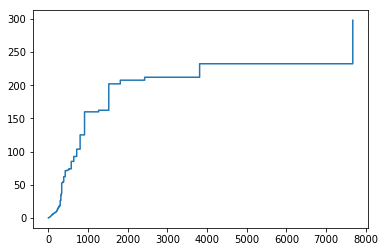

In [63]:
avg_fap = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_fap_outlier_detector")
avg_det_delay = np.fromfile("/content/gdrive/My Drive/Project_DL/avg_det_delay_perf_red_50_outlier_detector")
true_positive_rate = np.fromfile("/content/gdrive/My Drive/Project_DL/true_positive_rate_perf_red_50_outlier_detector")
plt.plot(avg_fap, avg_det_delay, label='ADD_vs_FAP')
plt.show()

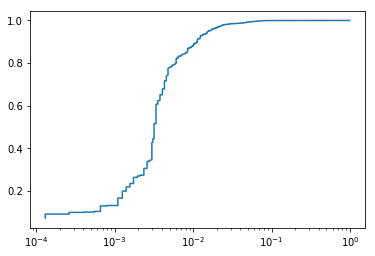

In [64]:
plt.semilogx(1/avg_fap, true_positive_rate, label='ROC_Curve')
plt.show()